## Shallow Shadows 

### Introduction
For a given ensemble of random unitaries $\{u\}$, the measurement or shadow channel $\mathcal{M}$ is defined as $\rho \rightarrow \mathcal{M}(\rho)=\mathbb{E}_u \left[  \sum_s \bra{s}u\rho u^\dagger \ket{s}u^\dagger \ket{s}\bra{s}u\right]$ where $\mathbb{E}_u$ denotes the average over the random unitary ensemble. For certain ensembles, in particular local (single-qubit) and global (N-qubit) unitaries from unitary 2-designs, the channel and its inverse $\mathcal{M}^{-1}$ can be computed analytically (Huang et al., Nat. Phys. 2020). We can then use it to construct classical shadows for arbitrary input states $\rho$: $\hat{\rho}=\mathcal{M}^{-1}(u^\dagger \ket{s}\bra{s}u)$ where $s$ is the outcome bitstring  of a single computational basis measurement performed on $u\rho u^\dagger$.

For more general ensembles of random unitaries, we need to learn the channel $\mathcal{M}$, then invert it to form shadows and obtain a randomized measurement protocol.

This notebook illustrates this for case of random unitaries formed by shallow random quantum circuits [Hu et al., PRR 5, 023027 (2023)](https://doi.org/10.1103/PhysRevResearch.5.023027), [Akhtar et al., Quantum 7, 1026 (2023)](https://quantum-journal.org/papers/q-2023-06-01-1026), [Bertoni et al, Phys. Rev. Lett. 133, 020602 (2024)](https://link.aps.org/doi/10.1103/PhysRevLett.133.020602) and [Hu et al.,Nat Commun 16, 2943 (2025)](https://doi.org/10.1038/s41467-025-57349-w). Importantly, we use the property that shallow random quantum circuits are locally scrambling circuits. This allows us to learn a representation of the channel from evaluating its action on single initial product state  [Hu et al., PRR 5, 023027 (2023)](https://doi.org/10.1103/PhysRevResearch.5.023027).

### Learning depolarization vectors
In Ref. [Hu et al., PRR 5, 023027 (2023)](https://doi.org/10.1103/PhysRevResearch.5.023027), it has been shown that with locally scrambling unitaries 
$$\mathcal{M}(\rho)=\sum_v c_v (\rho_{A(v)}\otimes 1_{B(v)}/2^{|B(v)|})$$
where we sum over all $2^N$ bitstrings $v=(v_1,v_2,\dots,v_N)$, and $A(v)=\{i| v_i=0\}$, and $B(v)=\{i|v_i=1\}$ denote the set of indices $i$ where $v_i$ is $0$ and $1$, respectively.
Thus, the "depolarization vector" $\vec{c} = (c_1,\dots,c_{2^N})$ fully specifies the channel $\mathcal{M}(\cdot)$.

Let us consider an initial state $\rho_0=\ket{0}\bra{0}$. We have the equality 
$$c_v=\mathrm{tr}(\mathcal{M}(\rho_0)O_v)$$
with $O_v=\bigotimes_{i}\left((\ket{0}\bra{0}-\ket{1}\bra{1})\delta_{v=1}+2(\ket{1}\bra{1})\delta_{v=0}\right)$. Therefore, the action of the channel $\mathcal{M}(\cdot)$ on the single initial state $\rho_0=\ket{0}\bra{0}$ fully specifies the vector $c_v$ and, hence, the channel $\mathcal{M}(\cdot)$.

To learn the vector $\vec{c}$, first we recall that 
$$\mathcal{M}(\rho_0)=\mathbb{E}_U\left[\sum_s \braket{s|U\rho_0U^\dag|s} U^\dag \ket{s}\bra{s} U \right].$$
 
Therefore, $c_v=\mathbb{E}_U[c_v(U)]$, with 
$$c_v(U)=\sum_s \braket{s|U\rho_0U^\dag|s} \braket{s|U O_v U^\dag|s}.$$

For a set of random unitaries $U$, these depolarization vectors $\vec{c}(U)=(c_1(U), \dots, c_{2^N}(U))$ can be computed as Matrix-Product-States (MPS) by evolving $\rho_0$ and $O_v$, using ITensor's internal routine [apply](https://itensor.github.io/ITensors.jl/dev/tutorials/MPSTimeEvolution.html),  and contracting the physical indices $s$. For instance, with a random circuit of depth 2, this is done as follows

In [1]:
using Revise
using RandomMeas

In [2]:
NU_training = 2000 # Number of unitaries
N = 10
site_indices_o = siteinds("Qubit", N;addtags="output")
site_indices_i = siteinds("Qubit", N;addtags="input")

depth = 2
ψ = random_mps(ComplexF64,site_indices_o;linkdims=2)


#measurement_group_training = MeasurementGroup(ψ,NU_training,NM_training;setting_type=ShallowUnitaryMeasurementSetting,depth=depth,mode=Dense)
settings = [ShallowUnitaryMeasurementSetting(N,depth;site_indices=site_indices_o) for _ in 1:NU_training]
shallow_depolarization_mps = get_shallow_depolarization_mps(settings);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:35K


### Fitting the average depolarization vector as an MPS

We now compute an matrix product state (MPS) approximation $\vec{c}$ of the average depolarization vector $ 1/{N_u}\sum_U c_v(U)$. To efficiently obtain such MPS approximation without actually computing the direct average $ 1/{N_u}\sum_U c_v(U)$ as a dense vector, we adapt a fitting algorithm presented in [T Baumgratz et al 2013 New J. Phys. 15 125004](https://iopscience.iop.org/article/10.1088/1367-2630/15/12/125004): We minimize the cost function $\vec{c}=\argmin_{\vec{x}}\mathcal{C}(\vec{x})$ with $$ \mathcal{C}(\vec{x}) =||\vec{x}-1/N_U\sum_U \vec{c}(U)||^2_2-||1/N_U\sum_U \vec{c}(U)||^2_2.$$ We note that the second term is constant (does not depend on $\vec{x}$) and has been added in order to facilitate the cost function evaluation (runtime $O(N_u)$ instead of $O(N_u^2)$). The compression algorithm updates each tensor sequentially over a finite number of sweeps.

In [3]:
nsweeps = 6 # Number of sweeps for the fitting 
χ = 4 # We minimize the cost function C in the space of MPS with the bond dimension χ.
average_shallow_depolarization_mps = get_average_mps(shallow_depolarization_mps,χ,nsweeps);

Cost function 1.013207294615339
Cost function -0.32950167495212773


Progress:  33%|█████████████▋                           |  ETA: 0:00:33

Cost function -0.3295046657799703


Progress:  50%|████████████████████▌                    |  ETA: 0:00:21

Cost function -0.3295050760060894


Progress:  67%|███████████████████████████▍             |  ETA: 0:00:12

Cost function -0.32950512544221544


Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:06

Cost function -0.3295051397299075


Progress: 100%|█████████████████████████████████████████| Time: 0:00:32
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


Cost function -0.32950514571867817


### Inverting the channel

For local invariant unitaries, the inverse channel has the following form ([Hu et al., PRR 5, 023027 (2023)](https://doi.org/10.1103/PhysRevResearch.5.023027)):
$$\mathcal{M}^{-1}(\sigma)=\sum_v d_v (\sigma_{A(v)}\otimes 1_{B(v)}/{2^{|B(v)|}})$$
with $\vec{d} = (d_1,\dots,d_{2^N})$.

Thus, we want to find a vector $\vec{d}$ such that, for all $\rho$, 
$$[\mathcal{M}^{-1}\circ\mathcal{M}](\rho)=\rho$$


This can be satisfied by minimizing the cost function

$$\mathcal{C}'(\vec{x})=||\mathcal{M}^{-1}\circ\mathcal{M}-1||_2^2$$

such that $\vec{d} = \argmin_{\vec{x}} \mathcal{C}'(\vec{x})$.

To do this efficiently, we parametrize $\vec{x}$ as an MPS with finite bond dimension $\chi$ and write $\mathcal{C}'(\vec{x})$ as a result of a tensor contraction, whose gradients with respects to the tensors of the MPS $\vec{x}$ can be evaluated by automatic differentations using the package Zygote. 

In [4]:
using OptimKit
shallow_map = get_depolarization_map(average_shallow_depolarization_mps,site_indices_i,site_indices_o)
site_indices_v = siteinds("Qubit", N)  # Virtual Site indices
inverse_depolarization_mps_data_init = randomMPS(Float64,site_indices_v;linkdims=χ).data

#evaluates the loss function defined above
loss(x) = loss_inverse_depolarization_map(x,shallow_map,site_indices_v,site_indices_i,site_indices_o)
println("initial loss ",loss(inverse_depolarization_mps_data_init))

#optimize!
optimizer = LBFGS(; maxiter=100, verbosity=1, gradtol = 1e-4)
loss_and_grad(x) = loss(x),loss'(x)
inverse_depolarization_mps_data, fs, gs, niter, normgradhistory = optimize(loss_and_grad, inverse_depolarization_mps_data_init, optimizer)
inverse_depolarization_mps = MPS(inverse_depolarization_mps_data)
inverse_shallow_map = get_depolarization_map(inverse_depolarization_mps,site_indices_i,site_indices_o);

initial loss 0.9999920052755431


┌ Warning: LBFGS: not converged to requested tol after 100 iterations and time 126.44 s: f = 0.001450156507, ‖∇f‖ = 8.8596e-03
└ @ OptimKit /home/vermersch/.julia/packages/OptimKit/G6i79/src/lbfgs.jl:197


## Simulated experiment
We are ready to perform an experiment on a unknown state $\ket{\psi}$, build shadows as MPO and estimate expectation values.

We aim to estimate XX correlations. We construct the corresponding MPOs and compute the exact expectation values.

In [5]:
ψ = random_mps(site_indices_o; linkdims=χ);

observable = Vector{MPO}()
for i in 1:N-1
    ampo = AutoMPO()
    ampo .+= "X", i,"X",i+1
    push!(observable,MPO(ampo,site_indices_o))
end

observable_exact = Vector{Float64}()
for o in observable
    push!(observable_exact,real(inner(ψ',o,ψ)))
end

For a given unitary, we know that the correspond shadow estimator for an observable $O$ can be written as 
$$O_e = \sum_s P_U(s) \mathrm{tr}(\mathcal{M}^{-1}(U^\dag\ket{s}\bra{s}U) O)=\sum_s P_U(s) \braket{s|U\mathcal{M}^{-1}(O)U^\dag|s}$$
where $P_U(s)$ is the estimated Born probability, and we have used the fact that $\mathcal{M}^{-1}$ is self-adjoint.

The expression given in the last term allows us to apply lest costly operations compared to the second term, but requires to form the probability vector $P_U(s)$ of dimension $2^N$. Let us check these two ways of estimating an observable for a single unitary

In [6]:
NU = 100
NM = 500
measurement_group_dense = MeasurementGroup(ψ,NU,NM;setting_type=ShallowUnitaryMeasurementSetting,depth=depth, mode=Dense);

In [7]:
r = 1 #First measurement setting
j = 1
measurement_data = measurement_group_dense.measurements[r]
##First method (slow, memoryefficient)
@time begin
    shadow_r = get_shallow_shadows(measurement_data,inverse_shallow_map,site_indices_i,site_indices_o)
    estimation_1 = real(get_expect_shadow(observable[j],shadow_r))
end
println("first method ", estimation_1)


##Second method (fast, memory ~2^N)
@time estimation_2 = real(get_expect_shadow(observable[j],measurement_data,inverse_shallow_map,site_indices_i,site_indices_o))
println("second method " , estimation_2)



 28.963674 seconds (43.65 M allocations: 6.541 GiB, 7.22% gc time, 71.21% compilation time)
first method -0.777749820473499
 32.240271 seconds (29.11 M allocations: 1.449 GiB, 1.38% gc time, 99.88% compilation time)
second method -0.7777498204734968


Therefore we will use the second method for this tutorial, and now postprocess over all measurement settings

In [8]:

using ProgressMeter
observable_e = zeros(Float64,N-1);
observable_e_square = zeros(Float64,N-1); #to assess statistical errors


@showprogress dt=1 for r in 1:NU
    measurement_data = measurement_group_dense.measurements[r]
    for j in 1:N-1
        term = real(get_expect_shadow(observable[j],measurement_data,inverse_shallow_map,site_indices_i,site_indices_o))
        observable_e[j] += term/NU
        observable_e_square[j] += term^2/NU
     end
end

observable_std = sqrt.(observable_e_square .- observable_e.^2)/sqrt(NU); # standard deviation on the mean

Progress: 100%|█████████████████████████████████████████| Time: 0:00:29


In [9]:
using Plots
using LaTeXStrings
plot_font = "Computer Modern"
default(fontfamily=plot_font,
        linewidth=2, framestyle=:box, label=nothing, grid=false)
scalefontsizes(1.6)

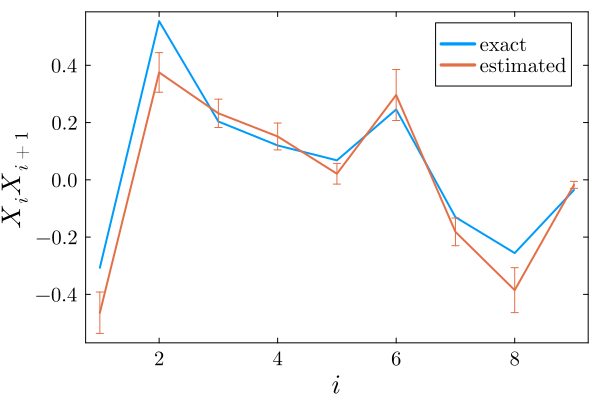

In [10]:
plot(observable_exact,label="exact")
plot!(observable_e,yerr=observable_std,msc=2,label="estimated")
xlabel!(L"$i$")
ylabel!(L"$X_iX_{i+1}$")